In [1]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'
# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'   # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))




In [2]:
# Group by 'specie' and 'Cluster_Label' and count the number of elements
grouped_data = data.groupby(['species', 'Cluster_Label']).size().reset_index(name='count')

In [3]:

species_clusters = data.groupby(['species', 'Cluster_Label']).size().unstack()
species_clusters.columns = [f'cluster_{i}' for i in species_clusters.columns]
species_clusters.fillna(0, inplace=True)

print(species_clusters)

                    cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
species                                                                     
ABULON                    0.0       12.0        0.0       20.0        0.0   
ALGAS                     0.0       39.0        0.0       38.0        0.0   
ALMEJA                   44.0     5285.0       25.0     2654.0       25.0   
ANCHOVETA                 0.0        3.0        0.0        2.0        0.0   
ATUN                      0.0        7.0        0.0      273.0        0.0   
BANDERA                  58.0     1065.0        1.0     7560.0       13.0   
BAQUETA                   0.0     6408.0       35.0     4768.0       19.0   
BARRILETE                 0.0       18.0        0.0      120.0        0.0   
BERRUGATA                16.0     4728.0        6.0     8935.0       19.0   
BESUGO                    0.0        0.0        0.0        1.0        0.0   
BONITO                    0.0       39.0        0.0       49.0        1.0   

In [10]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de R2
r2_df = pd.DataFrame(index=unique_species, columns=unique_clusters)


In [ ]:

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular el R2
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Calcular el R2 para los totales mensuales, si hay suficientes datos
            if not monthly_totals.empty:
                r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el R2 en el DataFrame
                r2_df.at[species_name, cluster_label] = r2
            else:
                #print(f'Sin datos suficientes para calcular R2 para especie: {species_name}, clúster: {cluster_label}')
                r2_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r2_df.at[species_name, cluster_label] = None

# Guardar el DataFrame de R2 en un archivo CSV
r2_output_path = os.path.join(results_directory, 'r2_scores2.csv')
r2_df.to_csv(r2_output_path)

print(f'Tabla de R2 guardada en: {r2_output_path}')

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Asegurar que las columnas estén en formato string y reindexar
r2_df.columns = r2_df.columns.astype(str)
r2_df = r2_df.reindex(columns=column_order)

# Asegurar que el índice también esté en formato string
r2_df.index = r2_df.index.astype(str)

# Reemplazar valores None o NaN con np.nan
r2_df = r2_df.apply(pd.to_numeric, errors='coerce')

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r2_df < -1) | (r2_df > 1) | r2_df.isna()


In [ ]:

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(r2_df, annot=True, cmap='viridis', cbar_kws={'label': 'R2 Score'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, annot_kws={"color": "black"})

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r2_df.shape[0]):
    for j in range(r2_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.2f}'.format(r2_df.iloc[i, j]), ha='center', va='center', color='white')

# Añadir títulos y etiquetas
plt.title('Heatmap of R2 Scores for Species and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()


/var/tmp/ipykernel_5235/2570516898.py:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/2570516898.py:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/2570516898.py:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/2570516898.py:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/2570516898.py:86: ConstantInputWarning: An input array is constant; the correlation coefficient is n

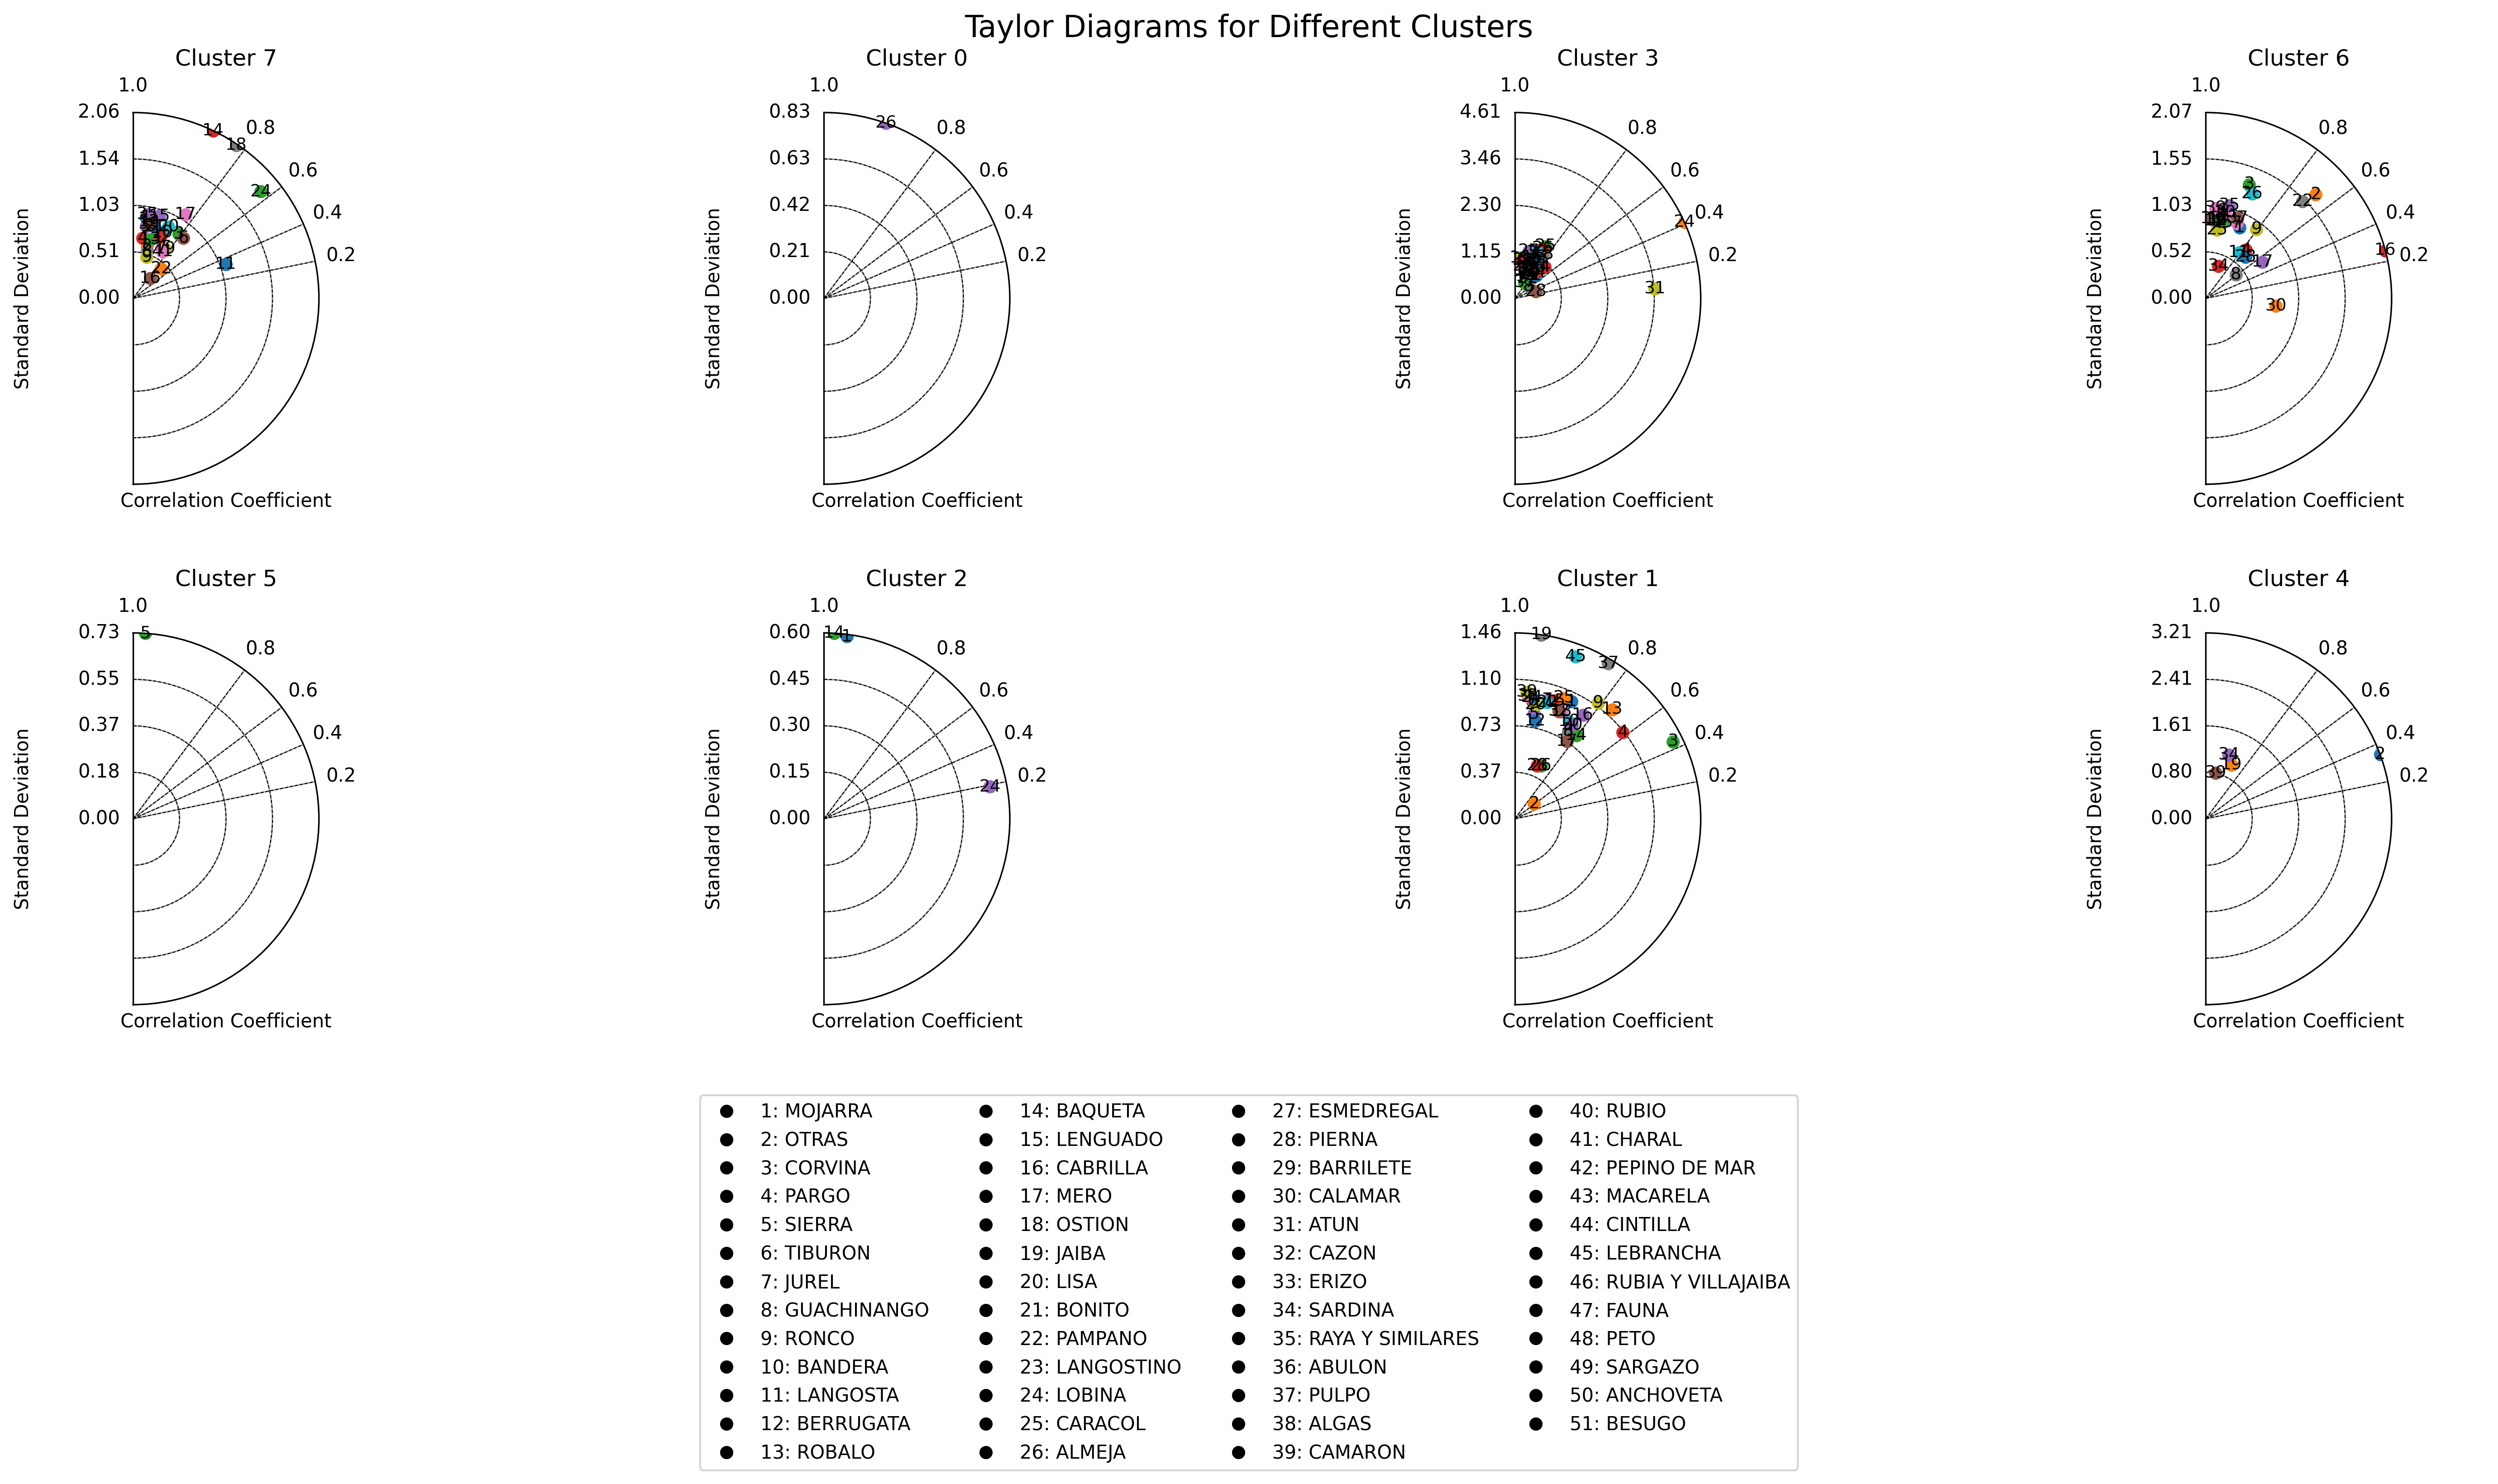

In [21]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_numbers, title):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo
    for i, (std, t) in enumerate(zip(stddev, theta)):
        ax.plot(t, std, 'o', label=f'Species {species_numbers[i]}')
        ax.text(t, std, str(species_numbers[i]), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.set_title(title)
    ax.grid(True)

    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Crear la figura para todos los subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'polar': True}, dpi=300)
axes = axes.flatten()

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Iterar sobre cada clúster para crear el diagrama de Taylor
for ax, cluster_label in zip(axes, unique_clusters):
    stddev = []
    corrcoef = []
    species_numbers = []
    
    for species_name in unique_species:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                
                # Almacenar los valores para el diagrama de Taylor
                stddev.append(std_pred / std_obs)
                corrcoef.append(corr)
                species_numbers.append(species_to_num[species_name])
    
    # Crear el diagrama de Taylor para el clúster actual
    if stddev and corrcoef:
        taylor_diagram(ax, stddev, corrcoef, species_numbers, title=f'Cluster {cluster_label}')

# Crear una única leyenda con nombres de especies y sus números
species_labels = [f'{num}: {species}' for species, num in species_to_num.items()]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=label) for label in species_labels]
fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Añadir títulos y etiquetas a los ejes
fig.suptitle('Taylor Diagrams for Different Clusters', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.25)
plt.show()


/var/tmp/ipykernel_5235/715160692.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/715160692.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/715160692.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/715160692.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_5235/715160692.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not de

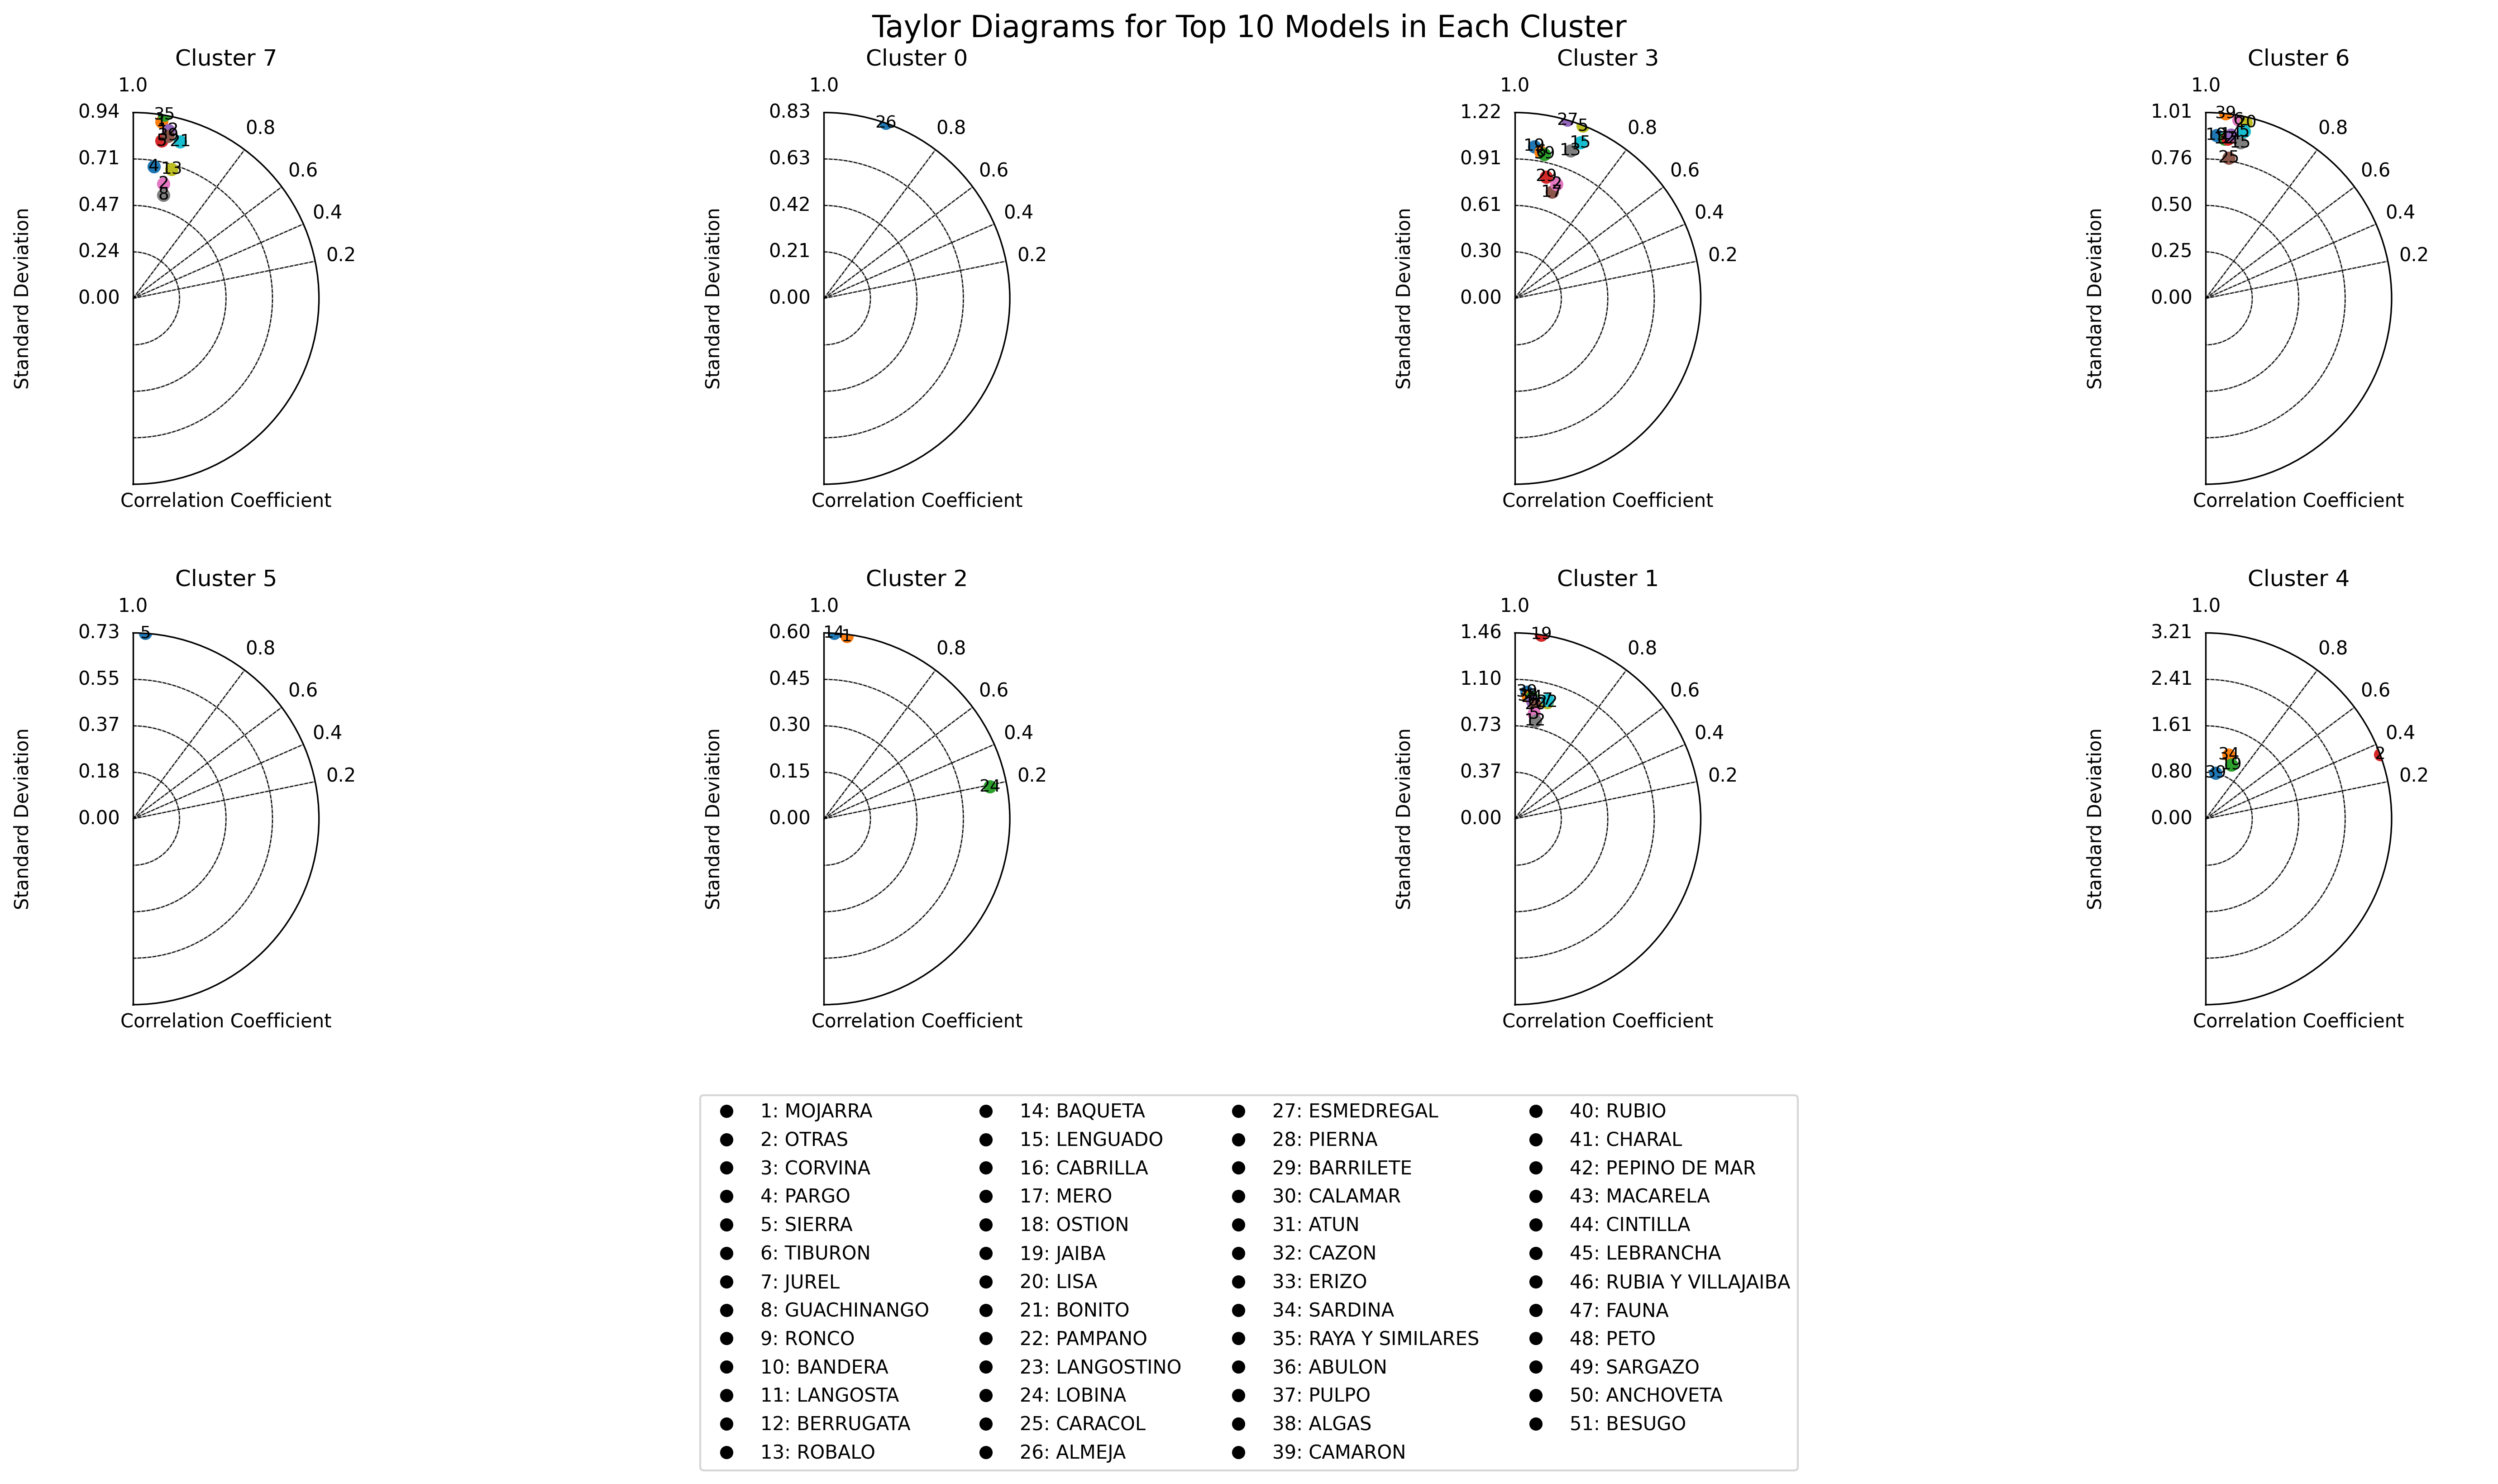

In [20]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar una lista para almacenar los valores de rendimiento
performance_data = []

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r y stddev
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                
                # Almacenar los valores en la lista
                performance_data.append({
                    'species': species_name,
                    'cluster': cluster_label,
                    'stddev': std_pred / std_obs,
                    'r': corr
                })

# Convertir la lista en un DataFrame
performance_df = pd.DataFrame(performance_data)

# Seleccionar los top 5 modelos para cada clúster
top_5_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(10, 'r')).reset_index(drop=True)

# Crear la figura para todos los subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'polar': True}, dpi=300)
axes = axes.flatten()

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_numbers, title):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo
    for i, (std, t) in enumerate(zip(stddev, theta)):
        ax.plot(t, std, 'o', label=f'Species {species_numbers[i]}')
        ax.text(t, std, str(species_numbers[i]), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.set_title(title)
    ax.grid(True)
    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Iterar sobre cada clúster para crear el diagrama de Taylor
for ax, cluster_label in zip(axes, unique_clusters):
    cluster_data = top_5_per_cluster[top_5_per_cluster['cluster'] == cluster_label]
    if not cluster_data.empty:
        stddev = cluster_data['stddev'].tolist()
        corrcoef = cluster_data['r'].tolist()
        species_numbers = [species_to_num[species] for species in cluster_data['species']]
        
        # Crear el diagrama de Taylor para el clúster actual
        taylor_diagram(ax, stddev, corrcoef, species_numbers, title=f'Cluster {cluster_label}')

# Crear una única leyenda con nombres de especies y sus números
species_labels = [f'{num}: {species}' for species, num in species_to_num.items()]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=label) for label in species_labels]
fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Añadir títulos y etiquetas a los ejes
fig.suptitle('Taylor Diagrams for Top 10 Models in Each Cluster', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.25)
plt.show()


In [18]:
import os
import pandas as pd

# Ruta del directorio donde se almacenan los modelos
models_directory = 'modelos_moe'  # Cambia esto a la ruta real de tu directorio de modelos

# Crear una lista de los modelos esperados solo para combinaciones que tienen datos
expected_models = []
for species in unique_species:
    for cluster in unique_clusters:
        # Filtrar los datos para la combinación específica de especie y clúster
        filtered_data = data[(data['species'] == species) & (data['Cluster_Label'] == cluster)].dropna()
        # Verificar si hay suficientes datos para entrenar
        if not filtered_data.empty:
            expected_models.append(f'{species}_cluster_{cluster}_moe_model.h5')

# Obtener la lista de archivos existentes en el directorio de modelos
existing_models = os.listdir(models_directory)

# Identificar los modelos faltantes
missing_models = [model for model in expected_models if model not in existing_models]

# Mostrar los modelos faltantes
print(f"Total de modelos esperados: {len(expected_models)}")
print(f"Total de modelos existentes: {len(existing_models)}")
print(f"Total de modelos faltantes: {len(missing_models)}")
print("Modelos faltantes:")
for model in missing_models:
    print(model)

# Opcional: Guardar la lista de modelos faltantes en un archivo CSV
missing_models_df = pd.DataFrame(missing_models, columns=['missing_models'])
missing_models_df.to_csv('missing_models.csv', index=False)

Total de modelos esperados: 301
Total de modelos existentes: 460
Total de modelos faltantes: 73
Modelos faltantes:
MOJARRA_cluster_4_moe_model.h5
OTRAS_cluster_4_moe_model.h5
PARGO_cluster_5_moe_model.h5
JUREL_cluster_0_moe_model.h5
JUREL_cluster_4_moe_model.h5
GUACHINANGO_cluster_0_moe_model.h5
GUACHINANGO_cluster_5_moe_model.h5
GUACHINANGO_cluster_4_moe_model.h5
RONCO_cluster_5_moe_model.h5
RONCO_cluster_2_moe_model.h5
RONCO_cluster_4_moe_model.h5
BANDERA_cluster_2_moe_model.h5
BERRUGATA_cluster_2_moe_model.h5
ROBALO_cluster_2_moe_model.h5
CABRILLA_cluster_0_moe_model.h5
MERO_cluster_0_moe_model.h5
OSTION_cluster_0_moe_model.h5
OSTION_cluster_4_moe_model.h5
JAIBA_cluster_0_moe_model.h5
BONITO_cluster_6_moe_model.h5
BONITO_cluster_4_moe_model.h5
PAMPANO_cluster_0_moe_model.h5
PAMPANO_cluster_5_moe_model.h5
PAMPANO_cluster_2_moe_model.h5
PAMPANO_cluster_4_moe_model.h5
LANGOSTINO_cluster_6_moe_model.h5
LANGOSTINO_cluster_2_moe_model.h5
LOBINA_cluster_0_moe_model.h5
LOBINA_cluster_5_moe_

/var/tmp/ipykernel_5235/1623770021.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(10, 'r')).reset_index(drop=True)


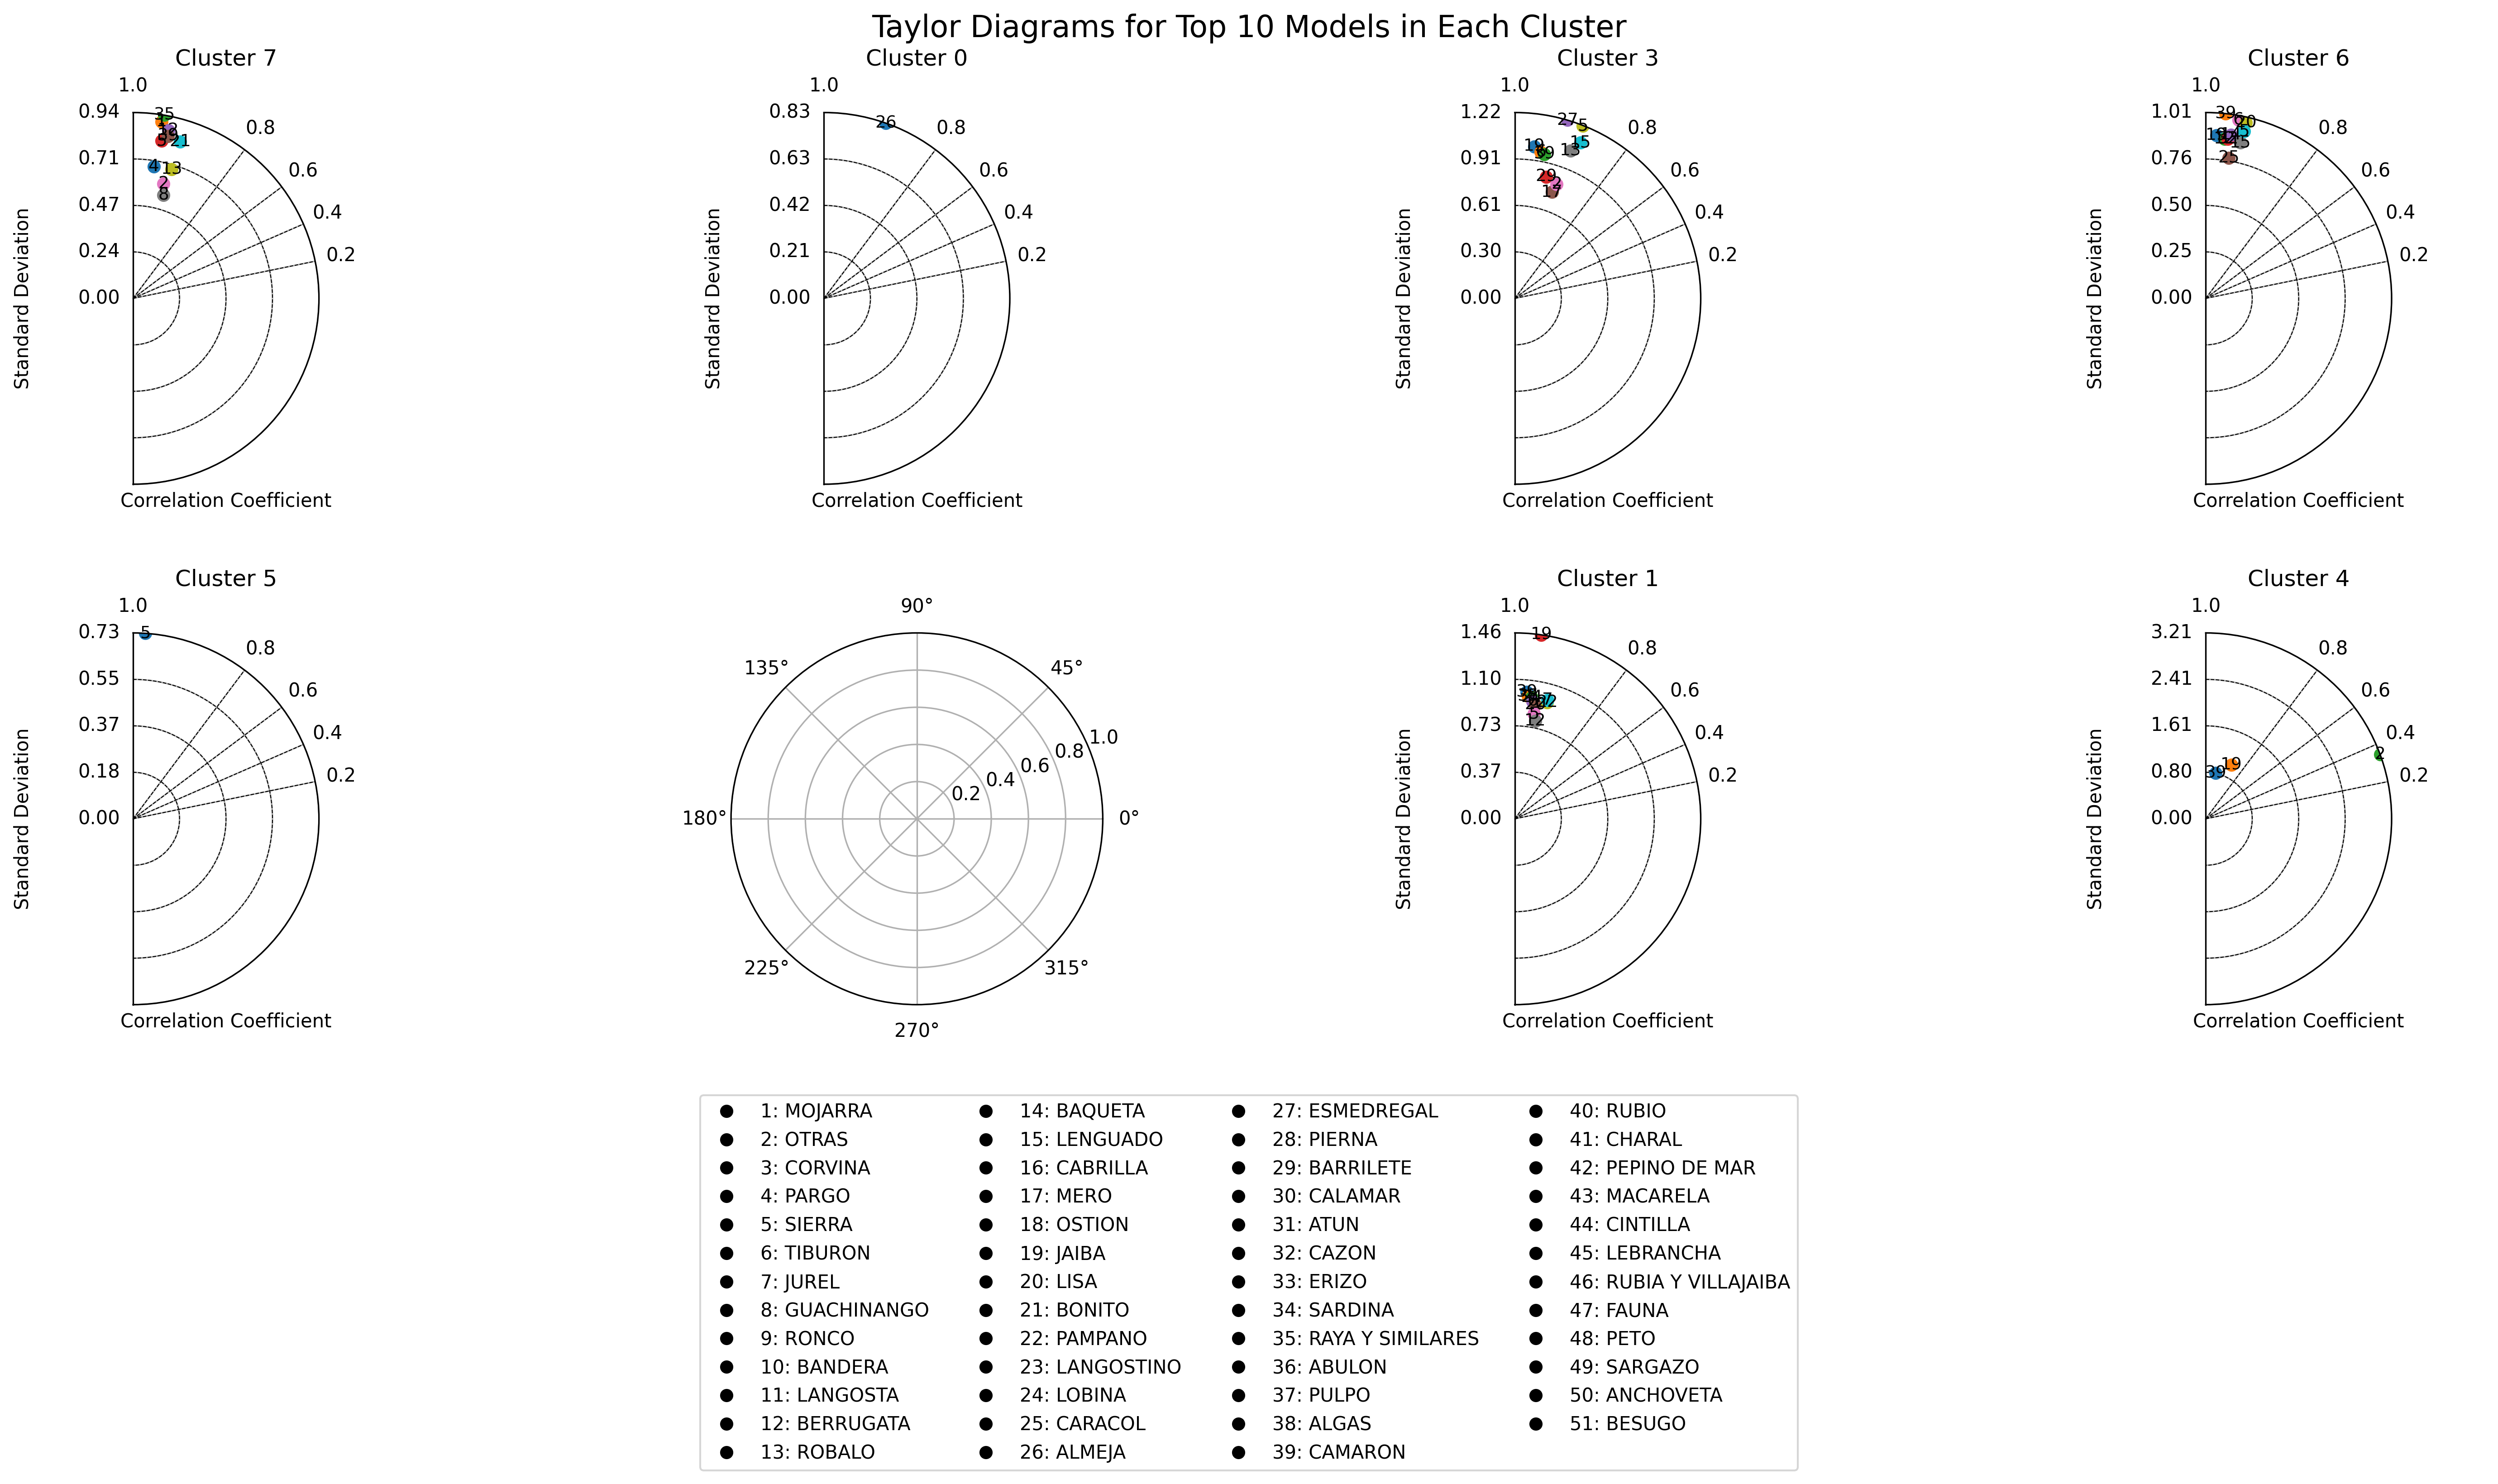

In [19]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar una lista para almacenar los valores de rendimiento
performance_data = []

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r y stddev
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                
                # Verificar si las series no son constantes
                if std_obs > 0 and std_pred > 0:
                    corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                    # Almacenar los valores en la lista
                    performance_data.append({
                        'species': species_name,
                        'cluster': cluster_label,
                        'stddev': std_pred / std_obs,
                        'r': corr
                    })

# Convertir la lista en un DataFrame
performance_df = pd.DataFrame(performance_data)

# Seleccionar los top 5 modelos para cada clúster
top_5_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(10, 'r')).reset_index(drop=True)

# Crear la figura para todos los subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'polar': True}, dpi=300)
axes = axes.flatten()

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_numbers, title):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo
    for i, (std, t) in enumerate(zip(stddev, theta)):
        ax.plot(t, std, 'o', label=f'Species {species_numbers[i]}')
        ax.text(t, std, str(species_numbers[i]), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.set_title(title)
    ax.grid(True)
    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Iterar sobre cada clúster para crear el diagrama de Taylor
for ax, cluster_label in zip(axes, unique_clusters):
    cluster_data = top_5_per_cluster[top_5_per_cluster['cluster'] == cluster_label]
    if not cluster_data.empty:
        stddev = cluster_data['stddev'].tolist()
        corrcoef = cluster_data['r'].tolist()
        species_numbers = [species_to_num[species] for species in cluster_data['species']]
        
        # Crear el diagrama de Taylor para el clúster actual
        taylor_diagram(ax, stddev, corrcoef, species_numbers, title=f'Cluster {cluster_label}')

# Crear una única leyenda con nombres de especies y sus números
species_labels = [f'{num}: {species}' for species, num in species_to_num.items()]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=label) for label in species_labels]
fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Añadir títulos y etiquetas a los ejes
fig.suptitle('Taylor Diagrams for Top 10 Models in Each Cluster', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.25)
plt.show()